In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import yt
from yt.units import dimensions
from yt.visualization.fixed_resolution import FixedResolutionBuffer

import numpy as np
import matplotlib.pyplot as plt

from sim import *
from read_ramses import *
from functions import *
import const


In [34]:
# choose simulation
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
print()

#dump = get_dump(aexp=0.1)
dump = 11
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)



Dump: 11
a_exp: 0.0645
Maximum AMR level: 13


In [36]:
info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
ds = yt.load(info_file)


yt : [INFO     ] 2025-01-23 09:59:17,431 Parameters: current_time              = 4.986446468616874
yt : [INFO     ] 2025-01-23 09:59:17,432 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 09:59:17,432 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 09:59:17,432 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 09:59:17,433 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 09:59:17,433 Parameters: current_redshift          = 14.508240570988766
yt : [INFO     ] 2025-01-23 09:59:17,433 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 09:59:17,433 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 09:59:17,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 09:59:17,434 Parameters: hubble_constant           = 0.703000030517578


In [37]:
use_cubic = True
use_override = True

halo_cat = get_halo_cat(dump, cgs=True)
biggest_halo_idx = np.argmax(halo_cat.mass)
biggest_halo_coord_mass = halo_cat.coord[:, biggest_halo_idx]
biggest_halo_coord_cubic = get_biggest_halo_coord_cubic(info.aexp) * info.length_unit
biggest_halo_coord_override = np.array([0.50761237,0.50874747,0.49581154]) * info.length_unit

print("Halo coord (mass): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_mass / info.length_unit))
print("Halo coord (cubic): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_cubic / info.length_unit))

if use_override: 
    biggest_halo_coord = biggest_halo_coord_override
elif use_cubic:
    biggest_halo_coord = biggest_halo_coord_cubic
else:
    biggest_halo_coord = biggest_halo_coord_mass
    
biggest_halo_coord_code = biggest_halo_coord / info.length_unit


Halo coord (mass): (0.50761, 0.50875, 0.49581)
Halo coord (cubic): (0.50757, 0.50883, 0.49581)


In [40]:
# define size and resolution of the region of interest

# tiny grid
amr_level = 13
box_size = 5 * const.kpc

# small grid
# amr_level = 12
# box_size = 8 * const.kpc

# medium grid
amr_level = 10
box_size = 20 * const.kpc

# large grid
amr_level = 8
box_size = 80 * const.kpc

left_edge = biggest_halo_coord - box_size / 2
left_edge_code = left_edge / info.length_unit
N = int(box_size / info.length_unit * ds.domain_dimensions[0] * 2**amr_level)
lowres = 2**(info.amr_level_max - amr_level)

print("Grid size: %d" % N)
print("Lowres factor: %d" % lowres)


Grid size: 285
Lowres factor: 32


In [41]:
# get raw yt data from the region of interest

smooth_grid = False

if smooth_grid:
    data = ds.smoothed_covering_grid(level=amr_level, left_edge=left_edge_code, dims=[N]*3)
else:
    data = ds.covering_grid(level=amr_level, left_edge=left_edge_code, dims=[N]*3)


yt : [WARNING  ] 2025-01-23 09:59:46,901 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,902 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,902 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,903 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,903 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,903 The cloud_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,903 The dust_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2025-01-23 09:59:46,904 The gas_tracer particle filter already exists. Overriding.
yt : [INFO     ] 2025-01-23 09:59:46,904 Adding particle_type: DM
yt : [INFO     ] 2025-01-23 09:59:46,914 Adding particle_type: star
yt : [INFO     ] 2025-01-23 09:59:46,923 Adding particle_type: cloud
yt : [INFO     ] 2

density max: [0.50759975 0.50873485 0.49579892]
star barycenter: [0.50576972 0.50735381 0.49649662]
dm barycenter: [0.507926   0.50891326 0.49598259]
center of mass: [0.50783498 0.50877959 0.4961011 ]


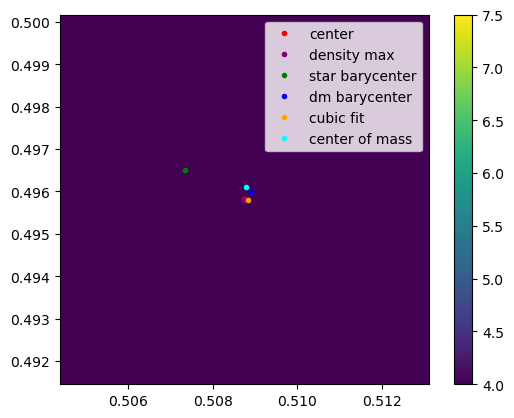

In [42]:
# quick look at the data

idx_slice = X
idx_coord1, idx_coord2 = np.sort([(idx_slice+1)%3, (idx_slice+2)%3])

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_star_code = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]]))
mass_star_code = data["io", "particle_mass"][is_star].value

coord_dm_code = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]]))
mass_dm_code = data["io", "particle_mass"][is_dm].value

coord_code = np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])
density_code = data["ramses", "Density"].value

plt.imshow(np.log10(np.sum(density_code, axis=idx_slice)).T, extent=[left_edge_code[idx_coord1], left_edge_code[idx_coord1] + box_size / info.length_unit, left_edge_code[idx_coord2], left_edge_code[idx_coord2] + box_size / info.length_unit], origin='lower', vmin=4, vmax=7.5)

x_idx, y_idx, z_idx = np.array(np.where(density_code == np.max(density_code))).T[0]
coord_code_density_max = coord_code[:, x_idx, y_idx, z_idx]
coord_code_star_barycenter = np.sum(coord_star_code * mass_star_code, axis=(1)) / np.sum(mass_star_code)
coord_code_dm_barycenter = np.sum(coord_dm_code * mass_dm_code, axis=(1)) / np.sum(mass_dm_code)
coord_code_com = np.sum(coord_code*density_code, axis=(1,2,3)) / np.sum(density_code)

print("density max: %s" % coord_code_density_max)
print("star barycenter: %s" % coord_code_star_barycenter)
print("dm barycenter: %s" % coord_code_dm_barycenter)
print("center of mass: %s" % coord_code_com)

plt.plot(left_edge_code[idx_coord1] + box_size / info.length_unit / 2, left_edge_code[idx_coord2] + box_size / info.length_unit / 2, '.', color='red', label='center')
plt.plot(coord_code_density_max[idx_coord1], coord_code_density_max[idx_coord2], '.', color='purple', label='density max')
plt.plot(coord_code_star_barycenter[idx_coord1], coord_code_star_barycenter[idx_coord2], '.', color='green', label='star barycenter')
plt.plot(coord_code_dm_barycenter[idx_coord1], coord_code_dm_barycenter[idx_coord2], '.', color='blue', label='dm barycenter')
plt.plot(biggest_halo_coord_cubic[idx_coord1] / info.length_unit, biggest_halo_coord_cubic[idx_coord2] / info.length_unit, '.', color='orange', label='cubic fit')
plt.plot(coord_code_com[idx_coord1], coord_code_com[idx_coord2], '.', color='cyan', label='center of mass')
plt.legend()
plt.colorbar()


In [43]:
# read particle data from yt

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_dm = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_dm = data["io", "particle_mass"][is_dm] * info.mass_unit

coord_star = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_star = data["io", "particle_mass"][is_star].value * info.mass_unit
metallicity_star = data["io", "particle_metallicity"][is_star].value
tau_starbirth = data["io", "conformal_birth_time"][is_star].value
id_star = data["io", "particle_identity"][is_star].value.astype(int)
vel_star = (np.array([data["io", "particle_velocity_x"].value[is_star], data["io", "particle_velocity_y"].value[is_star], data["io", "particle_velocity_z"].value[is_star]])) * info.length_unit/info.time_unit


In [44]:
# read gas data from yt

coord = (np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])) * info.length_unit - left_edge[:, None, None, None] - box_size / 2
density = data["ramses", "Density"].value * info.density_unit
metallicity = data["ramses", "Metallicity"].value 
pressure = data["ramses", "Pressure"].value * info.energy_density_unit
energy_turb = data["ramses", "hydro_scalar_01"].value * info.vel_unit**2
ref_crit = data["ramses", "hydro_scalar_02"].value
b_turb = data["ramses", "hydro_scalar_03"].value
vel_vec = np.array([data["ramses", "x-velocity"].value, data["ramses", "y-velocity"].value, data["ramses", "z-velocity"].value]) * info.vel_unit
dx_local = np.zeros((N, N, N))


In [45]:
# compute local dx

# for i, z in enumerate(coord_code[Z][0, 0, :]):
#     sl = ds.slice(Z, z)
#     bounds = (left_edge[X]/info.length_unit, (left_edge[X]+box_size)/info.length_unit, left_edge[Y]/info.length_unit, (left_edge[Y]+box_size)/info.length_unit)
#     frb = FixedResolutionBuffer(sl, bounds, (N, N))
#     dx_local[:, :, i] = frb["dx"]
#     print(i, end="")


In [46]:
grid_name = "data_d%d_l%d_b%d" % (dump, lowres, int(box_size / const.kpc))
print("filename: %s.npz" % grid_name)

filename: data_d11_l32_b80.npz


In [47]:
safe_savez(
    grid_name,
    halo_idx=halo_cat.idx[biggest_halo_idx],
    halo_mass=halo_cat.mass[biggest_halo_idx],
    box_size=box_size,
    left_edge=left_edge,
    N=N,
    coord_dm=coord_dm,
    mass_dm=mass_dm,
    coord_star=coord_star,
    vel_star=vel_star,
    mass_star=mass_star,
    metallicity_star=metallicity_star,
    tau_starbirth=tau_starbirth,
    id_star=id_star,
    coord=coord,
    density=density,
    metallicity=metallicity,
    pressure=pressure,
    energy_turb=energy_turb,
    ref_crit=ref_crit,
    b_turb=b_turb,
    vel_vec=vel_vec,
    lowres=lowres,
    dx_local=dx_local,
    **info.__dict__
)


In [52]:
for dump in range(42, 53):
    
    sim = Sim(9, "fiducial", f"data_d{dump}_l1_b5.npz")
    coord_code = (sim.left_edge + sim.box_size/2)
    
    info = get_info(dump)
    info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
    ds = yt.load(info_file)
    
    amr_level = 9
    box_size = 80 * const.kpc

    left_edge = coord_code - box_size / 2
    left_edge_code = left_edge / info.length_unit
    N = int(box_size / info.length_unit * ds.domain_dimensions[0] * 2**amr_level)
    lowres = 2**(info.amr_level_max - amr_level)
    
    data = ds.covering_grid(level=amr_level, left_edge=left_edge_code, dims=[N]*3)
    
    particle_type = data["io", "particle_family"].value.astype(int)
    is_dm = particle_type == DM
    is_star = particle_type == STAR

    coord_dm = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]])) * info.length_unit - left_edge[:, None] - box_size / 2
    mass_dm = data["io", "particle_mass"][is_dm] * info.mass_unit

    coord_star = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]])) * info.length_unit - left_edge[:, None] - box_size / 2
    mass_star = data["io", "particle_mass"][is_star].value * info.mass_unit
    metallicity_star = data["io", "particle_metallicity"][is_star].value
    tau_starbirth = data["io", "conformal_birth_time"][is_star].value
    id_star = data["io", "particle_identity"][is_star].value.astype(int)
    vel_star = (np.array([data["io", "particle_velocity_x"].value[is_star], data["io", "particle_velocity_y"].value[is_star], data["io", "particle_velocity_z"].value[is_star]])) * info.length_unit/info.time_unit

    coord = (np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])) * info.length_unit - left_edge[:, None, None, None] - box_size / 2
    density = data["ramses", "Density"].value * info.density_unit
    metallicity = data["ramses", "Metallicity"].value 
    pressure = data["ramses", "Pressure"].value * info.energy_density_unit
    energy_turb = data["ramses", "hydro_scalar_01"].value * info.vel_unit**2
    ref_crit = data["ramses", "hydro_scalar_02"].value
    b_turb = data["ramses", "hydro_scalar_03"].value
    vel_vec = np.array([data["ramses", "x-velocity"].value, data["ramses", "y-velocity"].value, data["ramses", "z-velocity"].value]) * info.vel_unit
    dx_local = np.zeros((N, N, N))
    
    grid_name = "data_d%d_l%d_b%d" % (dump, lowres, int(box_size / const.kpc))
    np.savez(
        grid_name,
        halo_idx=halo_cat.idx[biggest_halo_idx],
        halo_mass=halo_cat.mass[biggest_halo_idx],
        box_size=box_size,
        left_edge=left_edge,
        N=N,
        coord_dm=coord_dm,
        mass_dm=mass_dm,
        coord_star=coord_star,
        vel_star=vel_star,
        mass_star=mass_star,
        metallicity_star=metallicity_star,
        tau_starbirth=tau_starbirth,
        id_star=id_star,
        coord=coord,
        density=density,
        metallicity=metallicity,
        pressure=pressure,
        energy_turb=energy_turb,
        ref_crit=ref_crit,
        b_turb=b_turb,
        vel_vec=vel_vec,
        lowres=lowres,
        dx_local=dx_local,
        **info.__dict__
    )
    
    print(f"Finished dump {dump}")
    

yt : [INFO     ] 2025-01-23 10:44:42,473 Parameters: current_time              = 4.170032659531777
yt : [INFO     ] 2025-01-23 10:44:42,474 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:44:42,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:44:42,475 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:44:42,476 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:44:42,476 Parameters: current_redshift          = 9.831222799862129
yt : [INFO     ] 2025-01-23 10:44:42,476 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:44:42,477 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:44:42,477 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:44:42,477 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:44:59,626 The DM particle f

Finished dump 42


yt : [INFO     ] 2025-01-23 10:46:15,304 Parameters: current_time              = 4.1616010899590945
yt : [INFO     ] 2025-01-23 10:46:15,306 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:46:15,307 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:46:15,308 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:46:15,308 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:46:15,308 Parameters: current_redshift          = 9.78743111682458
yt : [INFO     ] 2025-01-23 10:46:15,309 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:46:15,309 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:46:15,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:46:15,310 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:46:34,031 The DM particle f

Finished dump 43


yt : [INFO     ] 2025-01-23 10:47:51,168 Parameters: current_time              = 4.135775994637324
yt : [INFO     ] 2025-01-23 10:47:51,173 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:47:51,173 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:47:51,174 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:47:51,174 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:47:51,175 Parameters: current_redshift          = 9.653791453559027
yt : [INFO     ] 2025-01-23 10:47:51,175 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:47:51,175 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:47:51,175 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:47:51,175 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:48:08,217 The DM particle f

Finished dump 44


yt : [INFO     ] 2025-01-23 10:51:09,135 Parameters: current_time              = 4.109245114377646
yt : [INFO     ] 2025-01-23 10:51:09,136 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:51:09,137 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:51:09,137 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:51:09,138 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:51:09,138 Parameters: current_redshift          = 9.51745677111818
yt : [INFO     ] 2025-01-23 10:51:09,139 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:51:09,139 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:51:09,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:51:09,139 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:51:26,098 The DM particle fi

Finished dump 45


yt : [INFO     ] 2025-01-23 10:53:00,840 Parameters: current_time              = 4.099365045714909
yt : [INFO     ] 2025-01-23 10:53:00,842 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:53:00,842 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:53:00,842 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:53:00,843 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:53:00,843 Parameters: current_redshift          = 9.466882762860076
yt : [INFO     ] 2025-01-23 10:53:00,843 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:53:00,844 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:53:00,844 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:53:00,844 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:53:17,735 The DM particle f

Finished dump 46


yt : [INFO     ] 2025-01-23 10:54:49,352 Parameters: current_time              = 4.084420156003825
yt : [INFO     ] 2025-01-23 10:54:49,353 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:54:49,354 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:54:49,354 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:54:49,354 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:54:49,355 Parameters: current_redshift          = 9.390664448775713
yt : [INFO     ] 2025-01-23 10:54:49,355 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:54:49,355 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:54:49,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:54:49,356 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:55:06,175 The DM particle f

Finished dump 47


yt : [INFO     ] 2025-01-23 10:56:20,081 Parameters: current_time              = 4.059049004711398
yt : [INFO     ] 2025-01-23 10:56:20,082 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:56:20,083 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:56:20,083 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:56:20,084 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:56:20,084 Parameters: current_redshift          = 9.261829470593653
yt : [INFO     ] 2025-01-23 10:56:20,084 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:56:20,085 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:56:20,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:56:20,085 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:56:37,715 The DM particle f

Finished dump 48


yt : [INFO     ] 2025-01-23 10:57:48,151 Parameters: current_time              = 4.037810499267919
yt : [INFO     ] 2025-01-23 10:57:48,153 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:57:48,154 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:57:48,154 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:57:48,155 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:57:48,155 Parameters: current_redshift          = 9.15465210397236
yt : [INFO     ] 2025-01-23 10:57:48,156 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:57:48,156 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:57:48,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:57:48,156 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:58:05,527 The DM particle fi

Finished dump 49


yt : [INFO     ] 2025-01-23 10:59:13,402 Parameters: current_time              = 4.033945983367195
yt : [INFO     ] 2025-01-23 10:59:13,403 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 10:59:13,404 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 10:59:13,404 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 10:59:13,405 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 10:59:13,405 Parameters: current_redshift          = 9.135272563306033
yt : [INFO     ] 2025-01-23 10:59:13,405 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 10:59:13,405 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 10:59:13,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 10:59:13,406 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 10:59:33,388 The DM particle f

Finished dump 50


yt : [INFO     ] 2025-01-23 11:00:41,676 Parameters: current_time              = 4.009803442978253
yt : [INFO     ] 2025-01-23 11:00:41,678 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 11:00:41,679 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 11:00:41,679 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 11:00:41,680 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 11:00:41,680 Parameters: current_redshift          = 9.014154059952185
yt : [INFO     ] 2025-01-23 11:00:41,681 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 11:00:41,681 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 11:00:41,681 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 11:00:41,681 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 11:00:59,527 The DM particle f

Finished dump 51


yt : [INFO     ] 2025-01-23 11:02:09,474 Parameters: current_time              = 4.006908651932941
yt : [INFO     ] 2025-01-23 11:02:09,475 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-23 11:02:09,475 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-23 11:02:09,475 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-23 11:02:09,476 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-23 11:02:09,476 Parameters: current_redshift          = 8.999770892704936
yt : [INFO     ] 2025-01-23 11:02:09,476 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-23 11:02:09,477 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-23 11:02:09,477 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-23 11:02:09,477 Parameters: hubble_constant           = 0.703000030517578
yt : [WARNING  ] 2025-01-23 11:02:29,058 The DM particle f

Finished dump 52
